In [1]:
# Enter Open AI API Key
from getpass import getpass

OPENAI_KEY = getpass('Enter Open AI API Key: ')

In [2]:
# Setup Environment Variables
import os

os.environ['OPENAI_API_KEY'] = OPENAI_KEY

In [3]:
from langchain_openai import OpenAIEmbeddings

# details here: https://openai.com/blog/new-embedding-models-and-api-updates
openai_embed_model = OpenAIEmbeddings(model='text-embedding-3-small')

In [4]:
from langchain_core.runnables import RunnableLambda
from operator import itemgetter
from langchain_core.prompts import ChatPromptTemplate
from langchain_chroma import Chroma
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

In [5]:
# Formatted Markdown in the output of the cell, 
# including the heading, bullet points, and styled text.
from IPython.display import display, Markdown

def display_docs(docs):
    for doc in docs:
        print('Metadata:', doc.metadata)
        print('Content Brief:')
        display(Markdown(doc.page_content))
        print()

In [6]:
# load from disk
collection_info = "rbac_rag_store"
chroma_db = Chroma(persist_directory="my_db4",
                   collection_name = collection_info,
                   embedding_function=openai_embed_model)

chroma_db

In [7]:
rag_prompt = """You are an assistant who is an expert in question-answering tasks.
                Answer the following question using only the following pieces of retrieved context.
                If the answer is not in the context, do not make up answers, just say that you don't know.
                Keep the answer to the point based on the information from the context.

                Question:
                {question}

                Context:
                {context}

                Answer:
            """

# convert the raw template in to structured one,
# so we can easily ingest <question> and <context>
rag_prompt_template = ChatPromptTemplate.from_template(rag_prompt)

In [9]:

chatgpt = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def get_rbac_retriever(user_role: str):
    """
    Creates a retriever that filters documents based on the user's role.
    """
    return chroma_db.as_retriever(
        search_type="similarity",
        search_kwargs={"k": 3, "filter": {"access_level": user_role}}
    )

src_rag_response_chain = (
    {
        "context": (itemgetter('context')
                        |
                    RunnableLambda(format_docs)),
        "question": itemgetter("question")
    }
        |
    rag_prompt_template
        |
    chatgpt
        |
    StrOutputParser()
)

# This chain now expects a dictionary with "question" and "user_role"
rag_chain_with_rbac = (
    {
        "context": lambda x: get_rbac_retriever(x["user_role"]).invoke(x["question"]),
        "question": itemgetter("question"),
        "user_role": itemgetter("user_role") # Pass the role along for clarity if needed
    }
    | 
    RunnablePassthrough.assign(response=src_rag_response_chain)
)

# Example invocation for an engineer
engineer_query = "Who is receiving the highest salary?"
response = rag_chain_with_rbac.invoke({"question": engineer_query, "user_role": "hr"})

print(f"Question: {response['question']}\\n")
print(f"Role: {response['user_role']}\\n")
print(f"Answer: {response['response']}\\n")
print("--- Retrieved Context ---")
display_docs(response['context'])

Question: Who is receiving the highest salary?\n
Role: hr\n
Answer: Saanvi Chowdhury is receiving the highest salary, which is 1982774.95.\n
--- Retrieved Context ---
Metadata: {'access_level': 'hr', 'attendance_pct': 97.41, 'date_of_birth': '1975-03-02', 'date_of_joining': '2021-05-21', 'department': 'Business', 'email': 'sai.sharma@fintechco.com', 'employee_id': 'FINEMP1011', 'full_name': 'Sai Sharma', 'last_review_date': '2024-01-07', 'leave_balance': 24, 'leaves_taken': 7, 'location': 'Ahmedabad', 'manager_id': 'FINEMP1004', 'performance_rating': 5, 'role': 'Business Analyst', 'salary': 1129637.9}
Content Brief:


Employee Sai Sharma (ID: FINEMP1011) works as a Business Analyst in the Business department. Their email is sai.sharma@fintechco.com and they are based in Ahmedabad. Born on 1975-03-02, they joined the company on 2021-05-21 and report to manager ID FINEMP1004. Their current salary is 1129637.9, with 24 leave days remaining out of 7 taken. Attendance percentage is 97.41% and their latest performance rating is 5 (last reviewed on 2024-01-07).


Metadata: {'access_level': 'hr', 'attendance_pct': 99.17, 'date_of_birth': '1976-03-24', 'date_of_joining': '2023-06-22', 'department': 'Business', 'email': 'saanvi.chowdhury@fintechco.com', 'employee_id': 'FINEMP1084', 'full_name': 'Saanvi Chowdhury', 'last_review_date': '2024-06-10', 'leave_balance': 5, 'leaves_taken': 4, 'location': 'Pune', 'manager_id': 'FINEMP1004', 'performance_rating': 2, 'role': 'Business Analyst', 'salary': 1982774.95}
Content Brief:


Employee Saanvi Chowdhury (ID: FINEMP1084) works as a Business Analyst in the Business department. Their email is saanvi.chowdhury@fintechco.com and they are based in Pune. Born on 1976-03-24, they joined the company on 2023-06-22 and report to manager ID FINEMP1004. Their current salary is 1982774.95, with 5 leave days remaining out of 4 taken. Attendance percentage is 99.17% and their latest performance rating is 2 (last reviewed on 2024-06-10).


Metadata: {'access_level': 'hr', 'attendance_pct': 95.36, 'date_of_birth': '1978-10-20', 'date_of_joining': '2020-12-24', 'department': 'Finance', 'email': 'saanvi.banerjee@fintechco.com', 'employee_id': 'FINEMP1070', 'full_name': 'Saanvi Banerjee', 'last_review_date': '2024-02-04', 'leave_balance': 17, 'leaves_taken': 6, 'location': 'Pune', 'manager_id': 'FINEMP1000', 'performance_rating': 2, 'role': 'Credit Officer', 'salary': 1872784.84}
Content Brief:


Employee Saanvi Banerjee (ID: FINEMP1070) works as a Credit Officer in the Finance department. Their email is saanvi.banerjee@fintechco.com and they are based in Pune. Born on 1978-10-20, they joined the company on 2020-12-24 and report to manager ID FINEMP1000. Their current salary is 1872784.84, with 17 leave days remaining out of 6 taken. Attendance percentage is 95.36% and their latest performance rating is 2 (last reviewed on 2024-02-04).

## Evaluation Criteria

![](https://i.imgur.com/5S4FhMB.png)

The retrieval process generally includes these steps:

- Convert the initial input query into an embedding using an embedding model of your choice (e.g., OpenAI's `text-embedding-3` model).
- Conduct a vector search with the embedded input on a vector database that holds your vectorized knowledge base, retrieving the top-K most "similar" document chunks.
- Optionally user a Reranker to rerank the retrieved results

## Retriver Metrics

### Contextual Precision

- Our retrieval_context that are relevant to the given input are ranked higher than irrelevant ones.
- This important because, LLM avoid halluciation by giving more attention to earlier node(Eg Top 1 context)
- so if order wrong hallunication chance will be higher 

We going to use DeepEval framework, we have other opensource metric evaluation frameworks are there(ragas, opik), 
- Still we use DeepEval main reason is which other variety of evaluation metrics like ragas, G-Eval
- Works well in Local machine and cloud as well
- Its parallel prpcessing, we can evaluate entire dataset with minium code


In [140]:
# Example invocation for an engineer
engineer_query = "What were the key strategic objectives for Q2 2024 and how successful was FinSolve Technologies in achieving them?"
response = rag_chain_with_rbac.invoke({"question": engineer_query, "user_role": "finance"})

print(f"Question: {response['question']}\\n")
print(f"Role: {response['user_role']}\\n")
print(f"Answer: {response['response']}\\n")
print("--- Retrieved Context ---")
display_docs(response['context'])

Question: What were the key strategic objectives for Q2 2024 and how successful was FinSolve Technologies in achieving them?\n
Role: finance\n
Answer: The key strategic objectives for Q2 2024 included market expansion, particularly in Southeast Asia, and customer acquisition through digital advertising and influencer partnerships. FinSolve Technologies was successful in achieving these objectives, as evidenced by a revenue increase to $2.3 billion (up 25% YoY) and improved profitability, with a gross margin of 60% and net income of $275 million (up 12% YoY).\n
--- Retrieved Context ---
Metadata: {'access_level': 'finance', 'source': 'data/finance/quarterly_financial_report.md'}
Content Brief:


Quarterly Financial Report - FinSolve Technologies Inc. 2024

Executive Summary

In 2024, FinSolve Technologies Inc. delivered exceptional financial performance, achieving significant year-over-year (YoY) growth across all quarters. With a strategic focus on market expansion, customer acquisition, and operational efficiency, the company saw revenue increase from $2.1 billion in Q1 to $2.6 billion in Q4, alongside consistent improvements in gross margin, operating income, and net income. This report provides a comprehensive overview of FinSolve Technologies’s financial results, expense breakdowns, cash flow analyses, and risk mitigation strategies for each quarter of 2024, underscoring our commitment to sustainable growth and shareholder value.

Q1 - January to March 2024

Quarterly Financial Overview

Q1 2024 set a strong foundation for the year, with robust revenue growth and operational efficiency. Key financial highlights include:

Revenue: $2.1 billion, up 22% YoY, driven by strong customer acquisition and increased transaction volumes.

Gross Margin: 58%, reflecting effective cost management and pricing strategies.

Operating Income: $500 million, supported by streamlined operations and high-margin product offerings.

Net Income: $250 million, up 10% YoY, bolstered by revenue growth and operational efficiencies.

Marketing Spend: $500 million, focused on digital marketing campaigns and brand awareness initiatives to support European market entry.

Vendor Costs: $120 million, driven by increased marketing activities and employee training programs.

Quarterly Expense Breakdown

Expenses were strategically allocated to support growth initiatives:

Vendor Services: $120 million, with 40% ($48 million) allocated to marketing-related activities, including digital advertisements and corporate events.

Employee Benefits & HR: $45 million, up 15% YoY due to increased staffing and employee development programs.

Software Subscriptions: $45 million, up 18% YoY, reflecting expanded reliance on cloud-based platforms for operational scalability.

Other Operational Expenses: $30 million, covering travel, office supplies, and administrative costs.

Cash Flow Analysis

Cash flow performance underscored FinSolve Technologies’s financial health:

Cash Flow from Operations: $300 million, up 10% YoY, driven by strong revenue and efficient working capital management.

Cash Flow from Investing: $50 million, allocated to research and development (R&D) and market expansion initiatives.

Cash Flow from Financing: $20 million, reflecting net inflows for working capital optimization.

Risks & Mitigation

Risk: Increased vendor costs due to market conditions.

Mitigation: Initiated vendor negotiations and implemented cost reduction strategies to optimize procurement.

Risk: Delays in accounts payable processing.

Mitigation: Streamlined payment workflows and renegotiated vendor contracts to improve cash flow efficiency.

Q2 - April to June 2024

Quarterly Financial Overview

Q2 2024 built on Q1’s momentum, with accelerated revenue growth and improved profitability. Key financial highlights include:

Revenue: $2.3 billion, up 25% YoY, fueled by strong performance in existing markets and early traction in Southeast Asia.

Gross Margin: 60%, driven by higher-margin product offerings and operational efficiencies.

Operating Income: $550 million, reflecting increased revenue and disciplined cost management.

Net Income: $275 million, up 12% YoY, supported by robust top-line growth.

Marketing Spend: $550 million, primarily allocated to digital advertising and influencer partnerships to drive Southeast Asian expansion.

Vendor Costs: $125 million, increased due to regional marketing campaigns and influencer-driven initiatives.

Quarterly Expense Breakdown

Expenses were aligned with strategic growth objectives:

Vendor Services: $125 million, with 50% ($62.5 million) dedicated to influencer marketing and social media campaigns.

Employee Benefits & HR: $47 million, reflecting investments in employee development and retention programs.

Software Subscriptions: $47 million, maintaining high operational tech costs to support scalability.

Other Operational Expenses: $33 million, covering promotional events and regional marketing activities.

Cash Flow Analysis

Cash flow trends remained positive, supporting growth initiatives:

Cash Flow from Operations: $350 million, up 12% YoY, driven by increased revenue and efficient collections.

Cash Flow from Investing: $60 million, allocated to market entry efforts and product development.

Cash Flow from Financing: $25 million, supporting market expansion through additional financing.

Risks & Mitigation

Risk: Influencer marketing campaigns underperforming relative to expected ROI.

Mitigation: Shifted to performance-based influencer contracts to align costs with measurable outcomes.

Risk: Intensified competition in Southeast Asia.

Mitigation: Enhanced marketing strategies and forged strategic partnerships to strengthen market positioning.

Q3 - July to September 2024

Quarterly Financial Overview

Q3 2024 saw continued growth, with a focus on customer retention and Latin American market expansion. Key financial highlights include:

Revenue: $2.4 billion, up 30% YoY, driven by strong performance in loyalty programs and new market penetration.

Gross Margin: 62%, reflecting improved pricing strategies and cost efficiencies.

Operating Income: $600 million, supported by higher revenue and optimized operations.

Net Income: $300 million, up 15% YoY, bolstered by top-line growth and margin expansion.

Marketing Spend: $600 million, focused on customer retention initiatives and localized events in Latin America.

Vendor Costs: $130 million, driven by local partnerships and loyalty program implementation.

Quarterly Expense Breakdown

Expenses supported retention and expansion strategies:

Vendor Services: $130 million, with 35% ($45.5 million) allocated to loyalty programs and customer retention strategies.

Employee Benefits & HR: $50 million, reflecting increased recruitment and training costs to support growth.

Software Subscriptions: $50 million, maintaining investment in cloud-based infrastructure.

Other Operational Expenses: $35 million, covering events, merchant partnerships, and regional activities.

Cash Flow Analysis

Cash flow performance remained strong, enabling further investment:

Cash Flow from Operations: $400 million, up 15% YoY, driven by robust revenue and improved collections.

Cash Flow from Investing: $70 million, allocated to R&D and Latin American expansion efforts.

Cash Flow from Financing: $30 million, focused on securing long-term capital for growth.

Risks & Mitigation

Risk: Vendor cost inflation in Latin America.

Mitigation: Renegotiated terms with local suppliers to secure favorable pricing and reduce costs.

Risk: High Days Sales Outstanding (DSO) impacting cash flow.

Mitigation: Implemented improved invoicing and collection practices to accelerate receivables.

Q4 - October to December 2024

Quarterly Financial Overview

Q4 2024 capped the year with exceptional performance, driven by end-of-year promotions and B2B marketing. Key financial highlights include:

Revenue: $2.6 billion, up 35% YoY, fueled by holiday campaigns and enterprise client acquisitions.

Gross Margin: 64%, reflecting optimized pricing and operational efficiencies.

Operating Income: $650 million, supported by strong revenue and cost discipline.

Net Income: $325 million, up 18% YoY, driven by top-line growth and margin expansion.

Marketing Spend: $650 million, allocated to end-of-year promotions and B2B marketing campaigns.

Vendor Costs: $135 million, increased due to high sales volume during holiday campaigns.

Quarterly Expense Breakdown

Expenses were aligned with high-impact seasonal initiatives:

Vendor Services: $135 million, with 40% ($54 million) allocated to end-of-year promotions and B2B marketing efforts.

Employee Benefits & HR: $55 million, driven by seasonal hiring and performance-based incentives.

Software Subscriptions: $55 million, consistent with prior quarters to support operational scalability.

Other Operational Expenses: $40 million, covering final-quarter events and administrative costs.

Cash Flow Analysis

Cash flow performance supported long-term growth:

Cash Flow from Operations: $450 million, up 18% YoY, driven by strong holiday sales and efficient working capital management.

Cash Flow from Investing: $80 million, allocated to product enhancements and global expansion.

Cash Flow from Financing: $35 million, securing funds for sustained growth in 2025.

Risks & Mitigation

Risk: Increased vendor charges during the holiday season.

Mitigation: Streamlined procurement processes and negotiated fixed-cost agreements to control expenses.

Risk: Revenue growth pressure in North America due to market saturation.

Mitigation: Launched aggressive digital marketing campaigns to capture additional market share.

2024 Annual Summary

FinSolve Technologies Inc. achieved remarkable financial results in 2024, with total revenue of $9.4 billion, a 28% YoY increase. Gross margin improved from 58% in Q1 to 64% in Q4, reflecting enhanced pricing strategies and operational efficiencies. Net income grew to $1.15 billion, up 14% YoY, driven by consistent revenue growth and cost discipline. Marketing spend totaled $2.3 billion, supporting global expansion and customer acquisition, while vendor costs rose modestly to $510 million due to strategic investments in regional campaigns and loyalty programs.

Cash flow from operations reached $1.5 billion, up 14% YoY, enabling $260 million in investments for R&D, market expansion, and product development. Financing activities provided $110 million to support working capital and long-term growth. Despite risks such as vendor cost inflation and competitive pressures, proactive mitigation strategies ensured financial stability and positioned FinSolve Technologies for continued success in 2025.

Recommendations for 2025

Optimize Marketing ROI: Leverage data analytics to refine influencer and digital marketing strategies, ensuring higher returns on ad spend.

Expand Cost Controls: Continue vendor negotiations and explore automation to reduce operational and vendor costs.

Accelerate Global Expansion: Increase investment in high-growth regions like Southeast Asia and Latin America to sustain revenue growth.

Enhance Cash Flow Management: Further streamline accounts receivable processes to reduce DSO and improve liquidity.

Conclusion

FinSolve Technologies Inc.’s 2024 performance reflects our strategic focus on growth, efficiency, and customer-centric innovation. With record-breaking revenue, improved margins, and strong cash flow, we are well-positioned to capitalize on global opportunities in 2025. This report highlights our commitment to delivering value to stakeholders while navigating market challenges with agility and foresight.


Metadata: {'access_level': 'finance', 'source': 'data/finance/financial_summary.md'}
Content Brief:


Financial Report for FinSolve Technologies Inc. - 2024

Executive Summary:

2024 marked a year of both opportunity and challenge for FinSolve Technologies. Despite a robust revenue increase, we saw significant pressure in certain expense categories, notably vendor-related costs and software subscriptions. However, these pressures were balanced by cost-saving measures in operational efficiency, strong gross margin performance, and strategic investment in growth areas. The company is well-positioned to continue scaling its core offerings, but focused attention on cost optimization will be essential for maintaining profitability in the coming years.

Year-Over-Year (YoY) Analysis:

FinSolve Technologies's revenue grew by 25% in 2024, driven largely by the global expansion of its services, especially in Asia and Europe. This was accompanied by a 10% increase in vendor-related expenses, impacting overall profit margins. While gross profit increased by 25%, reflecting higher operational efficiency, net income saw a more modest increase of 12%. This suggests that while revenue growth is strong, controlling vendor costs and maintaining healthy cash flows remain key to long-term profitability.

Expense Breakdown by Category:

The primary drivers of expense in 2024 were:

Vendor Services - A total of $30M, representing a 18% increase from the previous year. The largest contributors were:

Marketing-related expenses (Dinner, corporate events) – 40% of vendor services.

Training and education expenses – 30% of vendor services.

Software subscriptions (cloud services, licensing) – 25% of vendor services.

Other miscellaneous expenses – 5% of vendor services.

Analysis: The Dinner and Training categories accounted for an increasing share of the marketing budget. While essential for brand positioning, these expenses need tighter management, potentially through vendor renegotiations or reduced event frequency.

Software Subscriptions - A significant expense totaling $25M, up 22% from 2023. Given the heavy reliance on cloud-based tools and SaaS subscriptions, this area could benefit from more rigorous contract negotiation and potential consolidation of service providers.

Employee Benefits and HR Costs - With FinSolve Technologies's growth in headcount, HR expenses (benefits, recruitment, training) saw a 10% increase. While employee growth is essential, optimizing benefits packages and hiring processes could reduce per-employee cost.

Other Operational Expenses - A mix of general operational and administrative expenses totaling $15M, with a notable increase in travel and miscellaneous office costs, which grew by 8% year-over-year.

Cash Flow Analysis:

FinSolve Technologies’s cash flow from operations remained positive, amounting to $50M, a 20% increase over the prior year. However, the delayed payment cycles from several key vendors resulted in accounts payable delays, which slightly impacted cash liquidity during the second half of 2024. Addressing these delays, particularly in vendor payments, will be crucial to ensuring smoother cash flow management.

Cash Flow from Investing Activities: Investments in research and development, new market entry, and acquisitions amounted to $15M, representing 20% of total cash flows. While these investments are crucial for long-term growth, they reduced short-term liquidity, which is something that should be monitored closely.

Cash Flow from Financing Activities: Financing activities remained consistent, with a small net cash inflow of $5M, used primarily for working capital management and capital expenditure.

Key Financial Ratios and Metrics:

Gross Margin: 60% (Up from 55% in 2023)

Industry Benchmark: 55% (Indicates FinSolve Technologies is performing above average in terms of operational efficiency and cost control relative to peers).

Net Margin: 12% (Consistent with 2023)

Industry Benchmark: 10%

FinSolve Technologies’s stable net margin indicates sound control over both direct and indirect costs, though further improvement is possible with better vendor management.

Return on Investment (ROI): 15%

Industry Benchmark: 12%

This figure shows efficient use of invested capital, outpacing the industry, and is a positive indicator for investor confidence.

Operating Expenses to Revenue Ratio: 40%

Industry Benchmark: 45%

A lower operating expense ratio than industry peers suggests strong operational discipline.

Days Sales Outstanding (DSO): 45 days

Industry Benchmark: 30 days

A high DSO indicates that receivables collection could be improved. Optimizing payment cycles will be key for cash flow stability.

Operational Insights:

In 2024, operational efficiency was significantly impacted by delays in payment cycles and rising vendor costs. The company achieved strong revenue growth, but it’s clear that managing vendor expenses and tightening accounts payable and receivable processes will be crucial for future profitability.

Recommendations:
1. Vendor Management: Continue negotiations for better pricing, especially in high-expense categories like marketing events and software subscriptions. Consider consolidating suppliers where possible to leverage better terms.
2. Automation in Vendor Payments: Automating the accounts payable process will reduce human errors, speed up payments, and help reduce overdue payments, which will positively impact cash flow.
3. Employee Cost Optimization: As the headcount grows, consider introducing more flexible benefits packages and using technology to reduce HR administrative costs.
4. Cost-Cutting in Non-Core Activities: Explore opportunities to reduce expenses in non-essential categories, including travel and certain office-related costs.

Risk Analysis and Mitigation Strategies:

Risk: Vendor Cost Inflation – Vendor services, particularly marketing and software subscriptions, have shown significant price inflation. To mitigate this, a comprehensive vendor risk management plan should be developed, ensuring that contracts are regularly reviewed, and prices negotiated.

Risk: Cash Flow Volatility – Delays in receivables and vendor payment cycles may lead to short-term cash flow volatility. Improved working capital management and streamlining payment processes can significantly reduce this risk.

Risk: Operational Scalability – As FinSolve Technologies scales, maintaining operational efficiency will become more challenging. This can be mitigated by investing in automation, streamlining workflows, and maintaining a leaner organizational structure.

Risk: Regulatory Compliance – As the company expands globally, navigating complex regulatory landscapes in different regions may introduce compliance risks. FinSolve Technologies must invest in legal and compliance teams to ensure adherence to local laws and regulations.

Appendices:

Detailed tables and charts are available in the financial statements section of the main report, showcasing YoY comparisons, expense breakdowns, and key ratios.

In [141]:
human_answer = """
This engineering document outlines the technical architecture, development processes, and operational guidelines for FinSolve's product ecosystem. It serves as a comprehensive guide for engineering teams, stakeholders, and partners to ensure alignment with FinSolve's mission: "To empower financial freedom through secure, scalable, and innovative technology solutions.
"""

retrieved_context = [doc.page_content for doc in response['context']]
retrieved_context

['Quarterly Financial Report - FinSolve Technologies Inc. 2024\n\nExecutive Summary\n\nIn 2024, FinSolve Technologies Inc. delivered exceptional financial performance, achieving significant year-over-year (YoY) growth across all quarters. With a strategic focus on market expansion, customer acquisition, and operational efficiency, the company saw revenue increase from $2.1 billion in Q1 to $2.6 billion in Q4, alongside consistent improvements in gross margin, operating income, and net income. This report provides a comprehensive overview of FinSolve Technologies’s financial results, expense breakdowns, cash flow analyses, and risk mitigation strategies for each quarter of 2024, underscoring our commitment to sustainable growth and shareholder value.\n\nQ1 - January to March 2024\n\nQuarterly Financial Overview\n\nQ1 2024 set a strong foundation for the year, with robust revenue growth and operational efficiency. Key financial highlights include:\n\nRevenue: $2.1 billion, up 22% YoY, dr

In [142]:
from deepeval.test_case import LLMTestCase
from deepeval.metrics import ContextualPrecisionMetric
from deepeval import evaluate

test_case = LLMTestCase(
    input=response['question'],
    actual_output=response['response'],
    expected_output=human_answer,
    retrieval_context=retrieved_context
)

metric = ContextualPrecisionMetric(
    threshold=0.5,
    model="gpt-4o",
    include_reason=True,
    verbose_mode=True
)

result = evaluate([test_case], [metric])

✨ You're running DeepEval's latest Contextual Precision Metric! (using gpt-4o, strict=False, async_mode=True)...

Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 1 test case(s) in parallel: |          |  0% (0/1) [Time Taken: 00:00, ?test case/s]

Evaluating 1 test case(s) in parallel: |██████████|100% (1/1) [Time Taken: 00:05,  5.72s/test case]

**************************************************
Contextual Precision Verbose Logs
**************************************************

Verdicts:
[
    {
        "verdict": "no",
        "reason": "The context focuses on financial performance metrics such as revenue, gross margin, operating income, and marketing spend, but it does not directly address the key strategic objectives for Q2 2024 or the success in achieving them."
    },
    {
        "verdict": "no",
        "reason": "While the context provides details on financial growth, expense breakdowns, and cash flow analysis, it lacks specific information about strategic objectives or an assessment of FinSolve Technologies' success in achieving them."
    }
]
 
Score: 0
Reason: The score is 0.00 because both nodes in the retrieval context are not relevant. The first node focuses on 'financial performance metrics such as revenue, gross margin, operating income, and marketing spend,' which does not address the key strategic objectiv

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI. 
‼️  Friendly reminder 😇: You can also run evaluations with ALL of deepeval's metrics directly on Confident AI 
instead.

In [143]:
print('Sucess:', result.test_results[0].metrics_data[0].success)
print('Score:', result.test_results[0].metrics_data[0].score)
print('Reason:', result.test_results[0].metrics_data[0].reason)

Sucess: False
Score: 0.0
Reason: The score is 0.00 because both nodes in the retrieval context are not relevant. The first node focuses on 'financial performance metrics such as revenue, gross margin, operating income, and marketing spend,' which does not address the key strategic objectives or success for Q2 2024. The second node 'provides details on financial growth, expense breakdowns, and cash flow analysis,' but also lacks information on strategic objectives or an evaluation of FinSolve Technologies' success. Hence, irrelevant nodes are ranked first and second.


### Define Multiple Questions check metrics

In [144]:
# step 1 - Create list of queries and role

# List of queries with roles
test_queries = [
    {"question": "What is the purpose of the engineering document?", "role": "engineer"},
    {"question": "Who is receiving the highest salary, and what are their full details?", "role": "hr"},
    {"question": "What is the companys policy on attendance and late arrivals?", "role": "employee"},
    {"question":"What does the 2024 Year-over-Year (YoY) financial analysis reveal about FinSolve Technologies' revenue, profit, and cost trends?","role": "finance"},
    {"question":"How was the $15M marketing budget allocated across different channels in 2024?","role":"marketing"}
]

In [145]:
# Step 2: Invoke the Chain for Each Query

responses = []

for item in test_queries:
    result = rag_chain_with_rbac.invoke({
        "question": item["question"],
        "user_role": item["role"]
    })
    
    # Store the result for evaluation
    responses.append({
        "question": result["question"],
        "user_role": result["user_role"],
        "response": result["response"],
        "context": result["context"]
    })

responses[0]

{'question': 'What is the purpose of the engineering document?',
 'user_role': 'engineer',
 'response': "The purpose of the engineering document is to outline the technical architecture, development processes, and operational guidelines for FinSolve's product ecosystem, serving as a comprehensive guide for engineering teams, stakeholders, and partners to ensure alignment with FinSolve's mission.",
 'context': [Document(metadata={'access_level': 'engineer', 'heading_level': 'H4'}, page_content='### 1.2 Purpose\nThis engineering document outlines the technical architecture, development processes, and operational guidelines for FinSolve\'s product ecosystem. It serves as a comprehensive guide for engineering teams, stakeholders, and partners to ensure alignment with FinSolve\'s mission: "To empower financial freedom through secure, scalable, and innovative technology solutions."'),
  Document(metadata={'access_level': 'engineer', 'heading_level': 'H4'}, page_content='### 1.4 Document Cont

In [146]:
# Prepare Expected output

expected_output = [
    """This engineering document outlines the technical architecture, development processes, and operational guidelines for FinSolve's product ecosystem. It serves as a comprehensive guide for engineering teams, stakeholders, and partners to ensure alignment with FinSolve's mission: "To empower financial freedom through secure, scalable, and innovative technology solutions.""",
    """Saanvi Chowdhury (ID: FINEMP1084) works as a Business Analyst in the Business department.Their email is saanvi.chowdhury@fintechco.com and they are based in Pune. Born on 1976-03-24, they joined the company on 2023-06-22 and report to manager ID FINEMP1004.Their current salary is 1982774.95, with 5 leave days remaining out of 4 taken.Attendance percentage is 99.17% and their latest performance rating is 2(last reviewed on 2024-06-10).""",
    """Attendance must be marked daily via biometric, swipe card, or HRMS app.Late arrivals/early departures must be notified to the manager.Three or more late arrivals in a month may attract disciplinary action.""",
    """FinSolve Technologies's revenue grew by 25% in 2024, driven largely by the global expansion of its services, especially in Asia and Europe. This was accompanied by a 10% increase in vendor-related expenses, impacting overall profit margins. While gross profit increased by 25%, reflecting higher operational efficiency, **net income** saw a more modest increase of 12%. This suggests that while revenue growth is strong, controlling vendor costs and maintaining healthy cash flows remain key to long-term profitability.""",
    """1. Digital Marketing: $7M (47%) - Focused on paid ads, influencer campaigns, and digital content.2. Event Marketing: $3M (20%) - Sponsorships, event organization, and travel.3. Public Relations and Brand Awareness: $2M (13%) - Press releases, media engagements, and sponsorships.4. Customer Retention: $1M (7%) - Email marketing, customer loyalty programs, and CRM tools.5. Market Research and Analytics: $2M (13%) - Market research, surveys, and customer analytics."""

    ]

In [147]:
from deepeval.test_case import LLMTestCase

test_cases = []

for r, expected in zip(responses, expected_output):
    test_case = LLMTestCase(
        input=r["question"],
        actual_output=r["response"],
        expected_output=expected,
        retrieval_context=[doc.page_content for doc in r['context']]
    )
    test_cases.append(test_case)


In [148]:
test_cases

[LLMTestCase(input='What is the purpose of the engineering document?', actual_output="The purpose of the engineering document is to outline the technical architecture, development processes, and operational guidelines for FinSolve's product ecosystem, serving as a comprehensive guide for engineering teams, stakeholders, and partners to ensure alignment with FinSolve's mission.", expected_output='This engineering document outlines the technical architecture, development processes, and operational guidelines for FinSolve\'s product ecosystem. It serves as a comprehensive guide for engineering teams, stakeholders, and partners to ensure alignment with FinSolve\'s mission: "To empower financial freedom through secure, scalable, and innovative technology solutions.', context=None, retrieval_context=['### 1.2 Purpose\nThis engineering document outlines the technical architecture, development processes, and operational guidelines for FinSolve\'s product ecosystem. It serves as a comprehensive

In [149]:
metric = ContextualPrecisionMetric(
    threshold=0.5,
    model="gpt-4o",
    include_reason=True,
    verbose_mode=True
)

result = evaluate(test_cases, [metric])

✨ You're running DeepEval's latest Contextual Precision Metric! (using gpt-4o, strict=False, async_mode=True)...

Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 5 test case(s) in parallel: |██        | 20% (1/5) [Time Taken: 00:05,  5.11s/test case]

**************************************************
Contextual Precision Verbose Logs
**************************************************

Verdicts:
[
    {
        "verdict": "yes",
        "reason": "The context directly outlines the policy on attendance and late arrivals: 'Attendance must be marked daily via biometric, swipe card, or HRMS app. Late arrivals/early departures must be notified to the manager. Three or more late arrivals in a month may attract disciplinary action.'"
    },
    {
        "verdict": "no",
        "reason": "The FAQs section does not address the company's policy on attendance and late arrivals, focusing instead on topics like maternity leave and overtime."
    },
    {
        "verdict": "no",
        "reason": "The Dress Code & Office Etiquette section is unrelated to attendance and late arrivals, as it discusses maintaining cleanliness, using meeting rooms, and phone etiquette."
    }
]
 
Score: 1.0
Reason: The score is 1.00 because the relevant node, whic

Evaluating 5 test case(s) in parallel: |██████    | 60% (3/5) [Time Taken: 00:05,  1.46s/test case]

**************************************************
Contextual Precision Verbose Logs
**************************************************

Verdicts:
[
    {
        "verdict": "yes",
        "reason": "The context provides a detailed 'Year-Over-Year (YoY) Analysis' that closely matches the expected output, particularly noting the 25% revenue growth, 10% vendor expense increase, 25% gross profit increase, and 12% net income growth."
    },
    {
        "verdict": "no",
        "reason": "While it mentions FinSolve Technologies' overall performance in 2024, it lacks specific details about YoY revenue, profit, and cost trends, which are crucial to the expected output."
    }
]
 
Score: 1.0
Reason: The score is 1.00 because the first node in the retrieval context provides a detailed 'Year-Over-Year (YoY) Analysis' that closely matches the expected output, noting specific figures like the 25% revenue growth and 12% net income growth. The second node lacks specific details about YoY revenue, 

Evaluating 5 test case(s) in parallel: |████████  | 80% (4/5) [Time Taken: 00:06,  1.26s/test case]

**************************************************
Contextual Precision Verbose Logs
**************************************************

Verdicts:
[
    {
        "verdict": "no",
        "reason": "The salary of Sai Sharma (1129637.9) is lower than Saanvi Chowdhury's salary, hence, not the highest."
    },
    {
        "verdict": "no",
        "reason": "The salary of Saanvi Banerjee (1872784.84) is lower than Saanvi Chowdhury's salary, hence, not the highest."
    },
    {
        "verdict": "yes",
        "reason": "Saanvi Chowdhury's details, including their salary of 1982774.95, matches the expected output and confirms they have the highest salary."
    }
]
 
Score: 0.3333333333333333
Reason: The score is 0.33 because the node in the third rank, which clearly states 'Saanvi Chowdhury's details, including their salary of 1982774.95, matches the expected output and confirms they have the highest salary,' should have been ranked higher. The first and second nodes are less relevant a

Evaluating 5 test case(s) in parallel: |██████████|100% (5/5) [Time Taken: 00:07,  1.43s/test case]

**************************************************
Contextual Precision Verbose Logs
**************************************************

Verdicts:
[
    {
        "verdict": "yes",
        "reason": "The context clearly provides a detailed breakdown of the $15M marketing budget for 2024, which matches the expected output: 'Digital Marketing: $7M (47%) \u2013 Focused on paid ads, influencer campaigns, and digital content...'."
    },
    {
        "verdict": "no",
        "reason": "This context focuses on Q4 2024 marketing efforts and strategic objectives, which are not directly relevant to the breakdown of the $15M budget for the entire year of 2024."
    },
    {
        "verdict": "no",
        "reason": "While this context discusses Q2 2024 marketing strategies and budget allocation, it does not provide the specific breakdown of the $15M annual budget across different marketing channels as required by the input question."
    }
]
 
Score: 1.0
Reason: The score is 1.00 because the r

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI. 
‼️  Friendly reminder 😇: You can also run evaluations with ALL of deepeval's metrics directly on Confident AI 
instead.

In [151]:
for i, test_result in enumerate(result.test_results):
    metric_data = test_result.metrics_data[0]
    
    print(f"\nTest Case {i + 1}")
    print("Question:", test_result.input)
    print("Actual Answer:", test_result.actual_output)
    print("Expected Answer:", test_result.expected_output)
    print("Success:", metric_data.success)
    print("Score:", metric_data.score)
    print("Reason:", metric_data.reason)



Test Case 1
Question: What is the companys policy on attendance and late arrivals?
Actual Answer: The company's policy on attendance and late arrivals requires daily attendance to be marked via biometric, swipe card, or HRMS app. Late arrivals or early departures must be notified to the manager, and three or more late arrivals in a month may attract disciplinary action.
Expected Answer: Attendance must be marked daily via biometric, swipe card, or HRMS app.Late arrivals/early departures must be notified to the manager.Three or more late arrivals in a month may attract disciplinary action.
Success: True
Score: 1.0
Reason: The score is 1.00 because the relevant node, which 'directly outlines the policy on attendance and late arrivals', is ranked first. Irrelevant nodes, such as the FAQs addressing 'topics like maternity leave and overtime' and the 'Dress Code & Office Etiquette section' discussing 'maintaining cleanliness', are appropriately ranked lower.

Test Case 2
Question: What is 

## Contextual Recall

Contextual Recall -  Here we are not going to consider LLM response, important components are **Expected Output** and **Context Text (TOP n contents based on simliarity)**
-  LLM will extract all statements mentioned in the **Expected Output** and try to find those statements in the **Retrieved context document chunk (node)**

CR = # of Attributable statements / Total # of Statements

if Expected Output has 2 statements , then Total # of Statements = 2 , if Only one context present in Context Text out of 2 then 

CR = 1/2 --> 0.5

In [152]:
from deepeval.metrics import ContextualRecallMetric
metric = ContextualRecallMetric(
    threshold=0.5,
    model="gpt-4o",
    include_reason=True,
    verbose_mode=True
)

result = evaluate(test_cases, [metric])

✨ You're running DeepEval's latest Contextual Recall Metric! (using gpt-4o, strict=False, async_mode=True)...

Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 5 test case(s) in parallel: |██        | 20% (1/5) [Time Taken: 00:03,  3.49s/test case]

**************************************************
Contextual Recall Verbose Logs
**************************************************

Verdicts:
[
    {
        "verdict": "yes",
        "reason": "The sentence is directly from the 1st node: 'This engineering document outlines the technical architecture, development processes, and operational guidelines for FinSolve's product ecosystem...'"
    },
    {
        "verdict": "yes",
        "reason": "The sentence is directly from the 1st node: 'It serves as a comprehensive guide for engineering teams, stakeholders, and partners to ensure alignment with FinSolve's mission...'"
    }
]
 
Score: 1.0
Reason: The score is 1.00 because every sentence in the expected output is directly supported by the content of the nodes in retrieval context. Great job!



Evaluating 5 test case(s) in parallel: |████      | 40% (2/5) [Time Taken: 00:04,  1.82s/test case]

**************************************************
Contextual Recall Verbose Logs
**************************************************

Verdicts:
[
    {
        "verdict": "yes",
        "reason": "The sentence is attributed to the 1st node: 'Attendance must be marked daily via biometric, swipe card, or HRMS app.'"
    },
    {
        "verdict": "yes",
        "reason": "The sentence is attributed to the 1st node: 'Late arrivals/early departures must be notified to the manager.'"
    },
    {
        "verdict": "yes",
        "reason": "The sentence is attributed to the 1st node: 'Three or more late arrivals in a month may attract disciplinary action.'"
    }
]
 
Score: 1.0
Reason: The score is 1.00 because every sentence in the expected output is perfectly attributed to the first node in the retrieval context. Great job!



Evaluating 5 test case(s) in parallel: |████████  | 80% (4/5) [Time Taken: 00:05,  1.13s/test case]

**************************************************
Contextual Recall Verbose Logs
**************************************************

Verdicts:
[
    {
        "verdict": "yes",
        "reason": "The sentence matches the 3rd node in the retrieval context: 'Employee Saanvi Chowdhury (ID: FINEMP1084) works as a Business Analyst in the Business department...'"
    },
    {
        "verdict": "yes",
        "reason": "The sentence matches the 3rd node in the retrieval context: 'Their email is saanvi.chowdhury@fintechco.com and they are based in Pune...'"
    },
    {
        "verdict": "yes",
        "reason": "The sentence matches the 3rd node in the retrieval context: 'Born on 1976-03-24, they joined the company on 2023-06-22 and report to manager ID FINEMP1004...'"
    },
    {
        "verdict": "yes",
        "reason": "The sentence matches the 3rd node in the retrieval context: 'Their current salary is 1982774.95, with 5 leave days remaining out of 4 taken...'"
    },
    {
        

Evaluating 5 test case(s) in parallel: |██████████|100% (5/5) [Time Taken: 00:11,  2.24s/test case]

**************************************************
Contextual Recall Verbose Logs
**************************************************

Verdicts:
[
    {
        "verdict": "yes",
        "reason": "The sentence matches with the 1st node in the retrieval context: 'Digital Marketing: $7M (47%) \u2013 Focused on paid ads, influencer campaigns, and digital content.'"
    },
    {
        "verdict": "yes",
        "reason": "The sentence matches with the 1st node in the retrieval context: 'Event Marketing: $3M (20%) \u2013 Sponsorships, event organization, and travel.'"
    },
    {
        "verdict": "yes",
        "reason": "The sentence matches with the 1st node in the retrieval context: 'Public Relations and Brand Awareness: $2M (13%) \u2013 Press releases, media engagements, and sponsorships.'"
    },
    {
        "verdict": "yes",
        "reason": "The sentence matches with the 1st node in the retrieval context: 'Customer Retention: $1M (7%) \u2013 Email marketing, customer loyalty p

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI. 
‼️  Friendly reminder 😇: You can also run evaluations with ALL of deepeval's metrics directly on Confident AI 
instead.

In [153]:
for i, test_result in enumerate(result.test_results):
    metric_data = test_result.metrics_data[0]
    
    print(f"\nTest Case - {i + 1} - Contextual Recall")
    print("Question:", test_result.input)
    print("Actual Answer:", test_result.actual_output)
    print("Expected Answer:", test_result.expected_output)
    print("Success:", metric_data.success)
    print("Score:", metric_data.score)
    print("Reason:", metric_data.reason)



Test Case - 1 - Contextual Recall
Question: What is the purpose of the engineering document?
Actual Answer: The purpose of the engineering document is to outline the technical architecture, development processes, and operational guidelines for FinSolve's product ecosystem, serving as a comprehensive guide for engineering teams, stakeholders, and partners to ensure alignment with FinSolve's mission.
Expected Answer: This engineering document outlines the technical architecture, development processes, and operational guidelines for FinSolve's product ecosystem. It serves as a comprehensive guide for engineering teams, stakeholders, and partners to ensure alignment with FinSolve's mission: "To empower financial freedom through secure, scalable, and innovative technology solutions.
Success: True
Score: 1.0
Reason: The score is 1.00 because every sentence in the expected output is directly supported by the content of the nodes in retrieval context. Great job!

Test Case - 2 - Contextual Re

### Contextual Relevancy

Measure the relevancy of the information in the **Retrieved context document chunk (node)** to the given **input query**

In [154]:
from deepeval.metrics import ContextualRelevancyMetric

metric = ContextualRelevancyMetric(
    threshold=0.5,
    model="gpt-4o",
    include_reason=True,
    verbose_mode=True
)

result = evaluate(test_cases, [metric])

✨ You're running DeepEval's latest Contextual Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 5 test case(s) in parallel: |██        | 20% (1/5) [Time Taken: 00:04,  4.69s/test case]

**************************************************
Contextual Relevancy Verbose Logs
**************************************************

Verdicts:
[
    {
        "verdicts": [
            {
                "statement": "Employee Sai Sharma (ID: FINEMP1011) works as a Business Analyst in the Business department. Their email is sai.sharma@fintechco.com and they are based in Ahmedabad. Born on 1975-03-02, they joined the company on 2021-05-21 and report to manager ID FINEMP1004. Their current salary is 1129637.9, with 24 leave days remaining out of 7 taken. Attendance percentage is 97.41% and their latest performance rating is 5 (last reviewed on 2024-01-07).",
                "verdict": "yes",
                "reason": null
            }
        ]
    },
    {
        "verdicts": [
            {
                "statement": "Employee Saanvi Banerjee (ID: FINEMP1070) works as a Credit Officer in the Finance department. Their email is saanvi.banerjee@fintechco.com and they are based in Pu

Evaluating 5 test case(s) in parallel: |████      | 40% (2/5) [Time Taken: 00:07,  3.62s/test case]

**************************************************
Contextual Relevancy Verbose Logs
**************************************************

Verdicts:
[
    {
        "verdicts": [
            {
                "statement": "Attendance must be marked daily via biometric, swipe card, or HRMS app.",
                "verdict": "yes",
                "reason": null
            },
            {
                "statement": "Late arrivals/early departures must be notified to the manager.",
                "verdict": "yes",
                "reason": null
            },
            {
                "statement": "Three or more late arrivals in a month may attract disciplinary action.",
                "verdict": "yes",
                "reason": null
            }
        ]
    },
    {
        "verdicts": [
            {
                "statement": "How do I apply for maternity leave?",
                "verdict": "no",
                "reason": "The statement is about applying for maternity leave

Evaluating 5 test case(s) in parallel: |████████  | 80% (4/5) [Time Taken: 00:13,  3.27s/test case]

**************************************************
Contextual Relevancy Verbose Logs
**************************************************

Verdicts:
[
    {
        "verdicts": [
            {
                "statement": "FinSolve Technologies's revenue grew by 25% in 2024, driven largely by the global expansion of its services, especially in Asia and Europe.",
                "verdict": "yes",
                "reason": null
            },
            {
                "statement": "This was accompanied by a 10% increase in vendor-related expenses, impacting overall profit margins.",
                "verdict": "yes",
                "reason": null
            },
            {
                "statement": "While gross profit increased by 25%, reflecting higher operational efficiency, net income saw a more modest increase of 12%.",
                "verdict": "yes",
                "reason": null
            },
            {
                "statement": "Operational Insights: In 2024, oper

Evaluating 5 test case(s) in parallel: |██████████|100% (5/5) [Time Taken: 00:16,  3.26s/test case]

**************************************************
Contextual Relevancy Verbose Logs
**************************************************

Verdicts:
[
    {
        "verdicts": [
            {
                "statement": "In 2024, the total marketing budget was $15M, allocated as follows: Digital Marketing: $7M (47%) \u2013 Focused on paid ads, influencer campaigns, and digital content. Event Marketing: $3M (20%) \u2013 Sponsorships, event organization, and travel. Public Relations and Brand Awareness: $2M (13%) \u2013 Press releases, media engagements, and sponsorships. Customer Retention: $1M (7%) \u2013 Email marketing, customer loyalty programs, and CRM tools. Market Research and Analytics: $2M (13%) \u2013 Market research, surveys, and customer analytics.",
                "verdict": "yes",
                "reason": null
            },
            {
                "statement": "Executive Summary: 2024 was a pivotal year for the Marketing Department at FinSolve Technologies, marked

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI. 
‼️  Friendly reminder 😇: You can also run evaluations with ALL of deepeval's metrics directly on Confident AI 
instead.

In [155]:
for i, test_result in enumerate(result.test_results):
    metric_data = test_result.metrics_data[0]
    
    print(f"\nTest Case - {i + 1} - Contextual Relevancy")
    print("Question:", test_result.input)
    print("Actual Answer:", test_result.actual_output)
    print("Expected Answer:", test_result.expected_output)
    print("Success:", metric_data.success)
    print("Score:", metric_data.score)
    print("Reason:", metric_data.reason)



Test Case - 1 - Contextual Relevancy
Question: Who is receiving the highest salary, and what are their full details?
Actual Answer: Employee Saanvi Chowdhury (ID: FINEMP1084) is receiving the highest salary. Their full details are as follows:

- Position: Business Analyst
- Department: Business
- Email: saanvi.chowdhury@fintechco.com
- Location: Pune
- Date of Birth: 1976-03-24
- Date Joined: 2023-06-22
- Manager ID: FINEMP1004
- Current Salary: 1982774.95
- Leave Days Remaining: 5 (out of 4 taken)
- Attendance Percentage: 99.17%
- Latest Performance Rating: 2 (last reviewed on 2024-06-10)
Expected Answer: Saanvi Chowdhury (ID: FINEMP1084) works as a Business Analyst in the Business department.Their email is saanvi.chowdhury@fintechco.com and they are based in Pune. Born on 1976-03-24, they joined the company on 2023-06-22 and report to manager ID FINEMP1004.Their current salary is 1982774.95, with 5 leave days remaining out of 4 taken.Attendance percentage is 99.17% and their latest 

See current approach is solid since recall and precision are strong, indicating relevant chunks are retrieved. However, low contextual relevancy suggests chunks contain extra unrelated information.

- As we know Except **general** and **engineering** documents we used **UnstructuredMarkdownLoader with mode = single** may be the reason for this drop
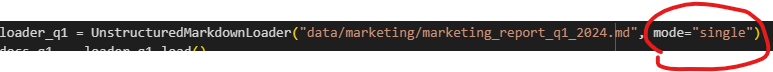

- Yes, by improving Split strategy we can improve this, but currently am not doing approach.

Example

If 5 documents (or chunks) are retrieved:

✅ Top 1 contains the answer → great for recall and precision..

❌ But the other 4 are irrelevant to the question → they hurt Contextual Relevancy

🔍 Why?
Relevancy metrics evaluate the entire retrieved context, not just whether the answer exists.

So if only 1 out of 5 chunks is relevant, you get a low score, even though the answer is correct and retrieved.

## Generation Metrics

The generation step, which comes after retrieval, generally includes:

- Building a prompt that combines the initial input with the context retrieved in the previous step.
- Feeding this prompt to your LLM, which produces the final generated response.

Key Metrics to Evaluate here include:

- Answer Relevancy
- Faithfulness
- Hallucination Check
- Custom LLM as a Judge (G-Eval)

Generation Metrics -  Measure the relevancy information in the generated response to the provided input query using LLM Judge


### Answer Relevancy - Generation Metrics

Idea - Instead of find cosine similarity between Input and LLM output, we going to ask LLM to generate question based on LLM response,
Now based the LLM generated question and our original question we going to find Average cosine similarity score.
Higher the score better the relevancy

Note - DeepEval has binding with RAGAS, which enables to use RAGASAnswerRelevancyMetrics


In [156]:
from deepeval.metrics import AnswerRelevancyMetric
metric = AnswerRelevancyMetric(
    threshold=0.5,
    model="gpt-4o",
    include_reason=True,
    verbose_mode=True
)

result = evaluate(test_cases, [metric])

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-4o, strict=False, async_mode=True)...

Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 5 test case(s) in parallel: |██        | 20% (1/5) [Time Taken: 00:04,  4.67s/test case]

**************************************************
Answer Relevancy Verbose Logs
**************************************************

Statements:
[
    "The company's policy on attendance and late arrivals requires daily attendance to be marked via biometric, swipe card, or HRMS app.",
    "Late arrivals or early departures must be notified to the manager.",
    "Three or more late arrivals in a month may attract disciplinary action."
] 
 
Verdicts:
[
    {
        "verdict": "yes",
        "reason": null
    },
    {
        "verdict": "yes",
        "reason": null
    },
    {
        "verdict": "yes",
        "reason": null
    }
]
 
Score: 1.0
Reason: The score is 1.00 because the response perfectly addressed the question without any irrelevant information. Great job staying on point!



Evaluating 5 test case(s) in parallel: |████      | 40% (2/5) [Time Taken: 00:05,  2.46s/test case]

**************************************************
Answer Relevancy Verbose Logs
**************************************************

Statements:
[
    "The purpose of the engineering document is to outline the technical architecture, development processes, and operational guidelines for FinSolve's product ecosystem.",
    "The document serves as a comprehensive guide for engineering teams, stakeholders, and partners.",
    "The document ensures alignment with FinSolve's mission."
] 
 
Verdicts:
[
    {
        "verdict": "yes",
        "reason": null
    },
    {
        "verdict": "yes",
        "reason": null
    },
    {
        "verdict": "yes",
        "reason": null
    }
]
 
Score: 1.0
Reason: The score is 1.00 because the response perfectly addresses the input question without any irrelevant information. Great job!



Evaluating 5 test case(s) in parallel: |██████    | 60% (3/5) [Time Taken: 00:07,  2.01s/test case]

**************************************************
Answer Relevancy Verbose Logs
**************************************************

Statements:
[
    "The $15M marketing budget for 2024 was allocated as follows:",
    "Digital Marketing: $7M (47%)",
    "Event Marketing: $3M (20%)",
    "Public Relations and Brand Awareness: $2M (13%)",
    "Customer Retention: $1M (7%)",
    "Market Research and Analytics: $2M (13%)"
] 
 
Verdicts:
[
    {
        "verdict": "yes",
        "reason": null
    },
    {
        "verdict": "yes",
        "reason": null
    },
    {
        "verdict": "yes",
        "reason": null
    },
    {
        "verdict": "yes",
        "reason": null
    },
    {
        "verdict": "yes",
        "reason": null
    },
    {
        "verdict": "yes",
        "reason": null
    }
]
 
Score: 1.0
Reason: The score is 1.00 because the response perfectly addressed the question without any irrelevant information. Great job!



Evaluating 5 test case(s) in parallel: |████████  | 80% (4/5) [Time Taken: 00:08,  1.85s/test case]

**************************************************
Answer Relevancy Verbose Logs
**************************************************

Statements:
[
    "The 2024 Year-over-Year (YoY) financial analysis reveals that FinSolve Technologies' revenue grew by 25%.",
    "Gross profit also increased by 25%.",
    "Net income saw a more modest increase of 12%.",
    "There are challenges in profit margins due to a 10% rise in vendor-related expenses.",
    "Revenue growth is strong.",
    "Controlling vendor costs and maintaining healthy cash flows are essential for long-term profitability."
] 
 
Verdicts:
[
    {
        "verdict": "yes",
        "reason": null
    },
    {
        "verdict": "yes",
        "reason": null
    },
    {
        "verdict": "yes",
        "reason": null
    },
    {
        "verdict": "yes",
        "reason": null
    },
    {
        "verdict": "yes",
        "reason": null
    },
    {
        "verdict": "idk",
        "reason": null
    }
]
 
Score: 1.0
Reason:

Evaluating 5 test case(s) in parallel: |██████████|100% (5/5) [Time Taken: 00:12,  2.51s/test case]

**************************************************
Answer Relevancy Verbose Logs
**************************************************

Statements:
[
    "Employee Saanvi Chowdhury (ID: FINEMP1084) is receiving the highest salary.",
    "Their full details are as follows:",
    "Position: Business Analyst",
    "Department: Business",
    "Email: saanvi.chowdhury@fintechco.com",
    "Location: Pune",
    "Date of Birth: 1976-03-24",
    "Date Joined: 2023-06-22",
    "Manager ID: FINEMP1004",
    "Current Salary: 1982774.95",
    "Leave Days Remaining: 5 (out of 4 taken)",
    "Attendance Percentage: 99.17%",
    "Latest Performance Rating: 2 (last reviewed on 2024-06-10)"
] 
 
Verdicts:
[
    {
        "verdict": "yes",
        "reason": null
    },
    {
        "verdict": "yes",
        "reason": null
    },
    {
        "verdict": "yes",
        "reason": null
    },
    {
        "verdict": "yes",
        "reason": null
    },
    {
        "verdict": "yes",
        "reason": null
 

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI. 
‼️  Friendly reminder 😇: You can also run evaluations with ALL of deepeval's metrics directly on Confident AI 
instead.

In [157]:
for i, test_result in enumerate(result.test_results):
    metric_data = test_result.metrics_data[0]
    
    print(f"\nTest Case - {i + 1} - Generator Metrics - Answer Relevancy")
    print("Question:", test_result.input)
    print("Actual Answer:", test_result.actual_output)
    print("Expected Answer:", test_result.expected_output)
    print("Success:", metric_data.success)
    print("Score:", metric_data.score)
    print("Reason:", metric_data.reason)



Test Case - 1 - Generator Metrics - Answer Relevancy
Question: What is the companys policy on attendance and late arrivals?
Actual Answer: The company's policy on attendance and late arrivals requires daily attendance to be marked via biometric, swipe card, or HRMS app. Late arrivals or early departures must be notified to the manager, and three or more late arrivals in a month may attract disciplinary action.
Expected Answer: Attendance must be marked daily via biometric, swipe card, or HRMS app.Late arrivals/early departures must be notified to the manager.Three or more late arrivals in a month may attract disciplinary action.
Success: True
Score: 1.0
Reason: The score is 1.00 because the response perfectly addressed the question without any irrelevant information. Great job staying on point!

Test Case - 2 - Generator Metrics - Answer Relevancy
Question: What is the purpose of the engineering document?
Actual Answer: The purpose of the engineering document is to outline the technic

### Faithfulness

The faithfulness metric measures the quality of your RAG pipeline's generator by evaluating whether the actual_output factually aligns with the contents of your retrieval_context.

Idea - Generated response are derived from only retrieval context, extract all the claim from LLM and check those claim are present in retrieval context

In deepeval, to use the FaithfulnessMetric, you'll have to provide the following arguments when creating an LLMTestCase:

- input : Input Query (not used in the computation)
- actual_output : Actual LLM Response
- retrieval_context : Top-N retrieved document chunks (nodes) from Vector DB

In [158]:
from deepeval.metrics import FaithfulnessMetric
metric = FaithfulnessMetric(
    threshold=0.5,
    model="gpt-4o",
    include_reason=True,
    verbose_mode=True
)

result = evaluate(test_cases, [metric])

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-4o, strict=False, async_mode=True)...

Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 5 test case(s) in parallel: |          |  0% (0/5) [Time Taken: 00:00, ?test case/s]

None
None
None
None
None


ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 2 time(s)...
Evaluating 5 test case(s) in parallel: |██        | 20% (1/5) [Time Taken: 00:14, 14.79s/test case]

**************************************************
Faithfulness Verbose Logs
**************************************************

Truths (limit=None):
[
    "Attendance must be marked daily via biometric, swipe card, or HRMS app.",
    "Late arrivals/early departures must be notified to the manager.",
    "Three or more late arrivals in a month may attract disciplinary action.",
    "To apply for maternity leave, submit application on HRMS with medical certificate at least 8 weeks before due date.",
    "If attendance is not marked, HR must be informed within 24 hours; repeated lapses may lead to deduction or disciplinary action.",
    "Overtime is paid at double the regular wage for hours beyond statutory limits, subject to manager approval.",
    "Working from home is allowed up to 2 days/week, subject to manager and business approval.",
    "Workspace cleanliness must be maintained.",
    "Meeting rooms should be used for calls/discussions.",
    "Mobile phones must be on silent in w

ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
Evaluating 5 test case(s) in parallel: |████      | 40% (2/5) [Time Taken: 00:19,  8.90s/test case]

**************************************************
Faithfulness Verbose Logs
**************************************************

Truths (limit=None):
[
    "FinSolve Technologies's revenue grew by 25% in 2024.",
    "FinSolve Technologies's vendor-related expenses increased by 10% in 2024.",
    "FinSolve Technologies's gross profit increased by 25% in 2024.",
    "FinSolve Technologies's net income increased by 12% in 2024.",
    "Vendor Services expenses totaled $30M in 2024.",
    "Marketing-related expenses accounted for 40% of vendor services in 2024.",
    "Training and education expenses accounted for 30% of vendor services in 2024.",
    "Software subscriptions accounted for 25% of vendor services in 2024.",
    "Software subscriptions expenses totaled $25M in 2024.",
    "Software subscriptions expenses increased by 22% from 2023 to 2024.",
    "Employee Benefits and HR Costs increased by 10% in 2024.",
    "Other Operational Expenses totaled $15M in 2024.",
    "Cash flow fro

ERROR:root:OpenAI rate limit exceeded. Retrying: 3 time(s)...
Evaluating 5 test case(s) in parallel: |██████    | 60% (3/5) [Time Taken: 00:21,  5.70s/test case]

**************************************************
Faithfulness Verbose Logs
**************************************************

Truths (limit=None):
[
    "Sai Sharma works as a Business Analyst in the Business department.",
    "Sai Sharma's employee ID is FINEMP1011.",
    "Sai Sharma's email is sai.sharma@fintechco.com.",
    "Sai Sharma is based in Ahmedabad.",
    "Sai Sharma was born on 1975-03-02.",
    "Sai Sharma joined the company on 2021-05-21.",
    "Sai Sharma reports to manager ID FINEMP1004.",
    "Sai Sharma's current salary is 1129637.9.",
    "Sai Sharma has 24 leave days remaining out of 7 taken.",
    "Sai Sharma's attendance percentage is 97.41%.",
    "Sai Sharma's latest performance rating is 5.",
    "Sai Sharma's last performance review was on 2024-01-07.",
    "Saanvi Banerjee works as a Credit Officer in the Finance department.",
    "Saanvi Banerjee's employee ID is FINEMP1070.",
    "Saanvi Banerjee's email is saanvi.banerjee@fintechco.com.",
    "Saanvi B

Evaluating 5 test case(s) in parallel: |████████  | 80% (4/5) [Time Taken: 00:27,  5.74s/test case]

**************************************************
Faithfulness Verbose Logs
**************************************************

Truths (limit=None):
[
    "FinSolve Technologies's marketing department achieved a 20% increase in new customer acquisition in 2024.",
    "FinSolve Technologies experienced a 15% growth in brand awareness in 2024.",
    "FinSolve Technologies's marketing initiatives delivered a solid return on investment (ROI) in 2024.",
    "FinSolve Technologies's marketing team increased new customers by 20%, outpacing the industry average of 10% growth.",
    "FinSolve Technologies's brand awareness grew by 15% in 2024.",
    "FinSolve Technologies's customer engagement rates increased by 5% in 2024.",
    "The 'InstantWire Global Expansion' campaign led to a 25% increase in website traffic and a 12% increase in sign-ups.",
    "FinSolve Technologies spent $5M on digital ads, influencer partnerships, and sponsored content in 2024.",
    "The digital marketing efforts ge

Evaluating 5 test case(s) in parallel: |██████████|100% (5/5) [Time Taken: 00:28,  5.61s/test case]

**************************************************
Faithfulness Verbose Logs
**************************************************

Truths (limit=None):
[
    "The engineering document outlines the technical architecture, development processes, and operational guidelines for FinSolve's product ecosystem.",
    "The document serves as a comprehensive guide for engineering teams, stakeholders, and partners.",
    "FinSolve's mission is to empower financial freedom through secure, scalable, and innovative technology solutions.",
    "The initial version of the document was created on 2025-05-01 by the Engineering Team.",
    "Version 1.1 of the document was updated on 2025-05-14 by the Tech Architecture Council.",
    "The AWS Well-Architected Framework is referenced in the document for cloud architecture best practices.",
    "PCI-DSS Guidelines are referenced in the document for payment security compliance.",
    "Kubernetes Documentation is referenced in the document for container orchest

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI. 
‼️  Friendly reminder 😇: You can also run evaluations with ALL of deepeval's metrics directly on Confident AI 
instead.

In [159]:
for i, test_result in enumerate(result.test_results):
    metric_data = test_result.metrics_data[0]
    
    print(f"\nTest Case - {i + 1} - Generator Metrics - Faithfulness")
    print("Question:", test_result.input)
    print("Actual Answer:", test_result.actual_output)
    print("Expected Answer:", test_result.expected_output)
    print("Success:", metric_data.success)
    print("Score:", metric_data.score)
    print("Reason:", metric_data.reason)



Test Case - 1 - Generator Metrics - Faithfulness
Question: What is the companys policy on attendance and late arrivals?
Actual Answer: The company's policy on attendance and late arrivals requires daily attendance to be marked via biometric, swipe card, or HRMS app. Late arrivals or early departures must be notified to the manager, and three or more late arrivals in a month may attract disciplinary action.
Expected Answer: Attendance must be marked daily via biometric, swipe card, or HRMS app.Late arrivals/early departures must be notified to the manager.Three or more late arrivals in a month may attract disciplinary action.
Success: True
Score: 1.0
Reason: The score is 1.00 because there are no contradictions, indicating perfect alignment between the actual output and the retrieval context. Well done!

Test Case - 2 - Generator Metrics - Faithfulness
Question: What does the 2024 Year-over-Year (YoY) financial analysis reveal about FinSolve Technologies' revenue, profit, and cost tren

### Hallucination Check¶
The hallucination metric determines whether your LLM generates factually correct information by comparing the actual_output to the provided (human ground truth) context.

deepeval's hallucination metric is a self-explaining LLM-Eval, meaning it outputs a reason for its metric score using an LLM as a Judge.

In deepeval, to use the HallucinationMetric, you'll have to provide the following arguments when creating an LLMTestCase:

- input : Input Query (not used in the computation)
- actual_output : Actual LLM Response
- context : Human Ground Truth Context Document Chunks (Nodes)

**Note** 
- Lower the score better the relevant
- Faithfulness gives score using retrieved context, while hallucination uses human-expected output

In [160]:
from deepeval.metrics import HallucinationMetric

# Create a new list of test cases with expected_output replaced by context, becoz context is the parameter
test_cases_with_context_as_expected = []

for case in test_cases:
    print(case.expected_output)
    test_cases_with_context_as_expected.append(
        LLMTestCase(
            input=case.input,
            actual_output=case.actual_output,
            context=[case.expected_output],
            retrieval_context=case.retrieval_context
        )
    )


metric = HallucinationMetric(
    threshold=0.5,
    model="gpt-4o",
    include_reason=True,
    verbose_mode=True
)

result = evaluate(test_cases_with_context_as_expected, [metric])

This engineering document outlines the technical architecture, development processes, and operational guidelines for FinSolve's product ecosystem. It serves as a comprehensive guide for engineering teams, stakeholders, and partners to ensure alignment with FinSolve's mission: "To empower financial freedom through secure, scalable, and innovative technology solutions.
Saanvi Chowdhury (ID: FINEMP1084) works as a Business Analyst in the Business department.Their email is saanvi.chowdhury@fintechco.com and they are based in Pune. Born on 1976-03-24, they joined the company on 2023-06-22 and report to manager ID FINEMP1004.Their current salary is 1982774.95, with 5 leave days remaining out of 4 taken.Attendance percentage is 99.17% and their latest performance rating is 2(last reviewed on 2024-06-10).
Attendance must be marked daily via biometric, swipe card, or HRMS app.Late arrivals/early departures must be notified to the manager.Three or more late arrivals in a month may attract discip

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-4o, strict=False, async_mode=True)...

Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 5 test case(s) in parallel: |          |  0% (0/5) [Time Taken: 00:00, ?test case/s]ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
Evaluating 5 test case(s) in parallel: |██████    | 60% (3/5) [Time Taken: 00:02,  1.26test case/s]

**************************************************
Hallucination Verbose Logs
**************************************************

Verdicts:
[
    {
        "verdict": "yes",
        "reason": "The actual output agrees with the provided context, as all categories and their corresponding budget allocations match the details given in the context."
    }
]
 
Score: 0.0
Reason: The score is 0.00 because the actual output fully aligns with the provided context without any contradictions.

**************************************************
Hallucination Verbose Logs
**************************************************

Verdicts:
[
    {
        "verdict": "yes",
        "reason": "The actual output agrees with the provided context. It mentions that FinSolve Technologies' revenue grew by 25%, gross profit increased by 25%, and net income increased by 12%, aligning with the context. It also acknowledges the 10% rise in vendor-related expenses impacting profit margins, consistent with the context'

ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
Evaluating 5 test case(s) in parallel: |██████████|100% (5/5) [Time Taken: 00:07,  1.56s/test case]

**************************************************
Hallucination Verbose Logs
**************************************************

Verdicts:
[
    {
        "verdict": "yes",
        "reason": "The actual output agrees with the provided context, accurately reflecting the purpose and content of the engineering document as outlined in the context."
    }
]
 
Score: 0.0
Reason: The score is 0.00 because the actual output fully aligns with the provided context, without any contradictions.

**************************************************
Hallucination Verbose Logs
**************************************************

Verdicts:
[
    {
        "verdict": "yes",
        "reason": "The actual output agrees with the provided context as all the details match, including the position, department, email, location, date of birth, date joined, manager ID, current salary, leave days remaining, attendance percentage, and latest performance rating."
    }
]
 
Score: 0.0
Reason: The score is 0.00 because

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI. 
‼️  Friendly reminder 😇: You can also run evaluations with ALL of deepeval's metrics directly on Confident AI 
instead.

In [161]:
for i, test_result in enumerate(result.test_results):
    metric_data = test_result.metrics_data[0]
    
    print(f"\nTest Case - {i + 1} - Generator Metrics - Hallucination")
    print("Question:", test_result.input)
    print("Actual Answer:", test_result.actual_output)
    print("Expected Answer:", test_result.expected_output)
    print("Success:", metric_data.success)
    print("Score:", metric_data.score)
    print("Reason:", metric_data.reason)



Test Case - 1 - Generator Metrics - Hallucination
Question: How was the $15M marketing budget allocated across different channels in 2024?
Actual Answer: The $15M marketing budget for 2024 was allocated as follows:

- Digital Marketing: $7M (47%)
- Event Marketing: $3M (20%)
- Public Relations and Brand Awareness: $2M (13%)
- Customer Retention: $1M (7%)
- Market Research and Analytics: $2M (13%)
Expected Answer: None
Success: True
Score: 0.0
Reason: The score is 0.00 because the actual output fully aligns with the provided context without any contradictions.

Test Case - 2 - Generator Metrics - Hallucination
Question: What does the 2024 Year-over-Year (YoY) financial analysis reveal about FinSolve Technologies' revenue, profit, and cost trends?
Actual Answer: The 2024 Year-over-Year (YoY) financial analysis reveals that FinSolve Technologies' revenue grew by 25%, while gross profit also increased by 25%. However, net income saw a more modest increase of 12%, indicating challenges in 

### G-Eval -  Custom LLM as a Judge
G-Eval is a framework that uses LLMs with chain-of-thoughts (CoT) to evaluate LLM outputs based on **ANY** custom criteria.

The G-Eval metric is the most versatile type of metric deepeval has to offer, and is capable of evaluating almost any use case with good accuracy.

Here you are free to describe your custom evaluation process in detail using prompts in evaluation_steps.

In deepeval, to use the GEval, you'll have to provide the following arguments when creating an LLMTestCase:

- input : Input Query (not used in the computation)
- actual_output : Actual LLM Response
we will also need to supply any additional arguments such as **expected_output** and context if your evaluation criteria depends on these parameters.

In [162]:
from deepeval.metrics import GEval
from deepeval.test_case import LLMTestCaseParams

metric = GEval(
    threshold=0.5,
    model="gpt-4o",
    name="RAG Fact Checker",
    # NOTE: you can only provide either criteria or evaluation_steps, and not both
    # criteria (High-level objective) and evaluation_steps (Detailed guidance)
    # example - criteria="Is the answer clear and complete?"
    evaluation_steps=[
        "Create a list of statements from 'actual output'",
        "Validate if they are relevant and answers the given question in 'input', penalize if any statements are irrelevant",
        "Also Validate if they exist in 'expected output', penalize if any statements are missing or factually wrong",
        "Also validate if these statements are grounded in the 'retrieval context' and penalize if they are missing or factually wrong",
        "Finally also penalize if any statements seem to be invented or made up and do not make sense factually given the 'input' and 'retrieval context'"
    ],
    evaluation_params=[LLMTestCaseParams.INPUT,
                       LLMTestCaseParams.ACTUAL_OUTPUT,
                       LLMTestCaseParams.EXPECTED_OUTPUT,
                       LLMTestCaseParams.RETRIEVAL_CONTEXT],
    verbose_mode=True
)

result = evaluate(test_cases, [metric])

✨ You're running DeepEval's latest RAG Fact Checker (GEval) Metric! (using gpt-4o, strict=False, 
async_mode=True)...

Event loop is already running. Applying nest_asyncio patch to allow async execution...


Evaluating 5 test case(s) in parallel: |          |  0% (0/5) [Time Taken: 00:00, ?test case/s]ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
Evaluating 5 test case(s) in parallel: |██        | 20% (1/5) [Time Taken: 00:03,  3.04s/test case]

**************************************************
RAG Fact Checker (GEval) Verbose Logs
**************************************************

Criteria:
None 
 
Evaluation Steps:
[
    "Create a list of statements from 'actual output'",
    "Validate if they are relevant and answers the given question in 'input', penalize if any statements are irrelevant",
    "Also Validate if they exist in 'expected output', penalize if any statements are missing or factually wrong",
    "Also validate if these statements are grounded in the 'retrieval context' and penalize if they are missing or factually wrong",
    "Finally also penalize if any statements seem to be invented or made up and do not make sense factually given the 'input' and 'retrieval context'"
]
 
Score: 0.8118833023637706
Reason: The actual output is relevant and answers the input question. It aligns with the expected output but omits the mission statement, which is present in the expected output and retrieval context. All other det

Evaluating 5 test case(s) in parallel: |████      | 40% (2/5) [Time Taken: 00:04,  1.82s/test case]

**************************************************
RAG Fact Checker (GEval) Verbose Logs
**************************************************

Criteria:
None 
 
Evaluation Steps:
[
    "Create a list of statements from 'actual output'",
    "Validate if they are relevant and answers the given question in 'input', penalize if any statements are irrelevant",
    "Also Validate if they exist in 'expected output', penalize if any statements are missing or factually wrong",
    "Also validate if these statements are grounded in the 'retrieval context' and penalize if they are missing or factually wrong",
    "Finally also penalize if any statements seem to be invented or made up and do not make sense factually given the 'input' and 'retrieval context'"
]
 
Score: 0.9962673113325187
Reason: All statements in the actual output are relevant to the input question and match the expected output. They are also supported by the retrieval context and do not include any invented information.



Evaluating 5 test case(s) in parallel: |██████    | 60% (3/5) [Time Taken: 00:08,  2.91s/test case]

**************************************************
RAG Fact Checker (GEval) Verbose Logs
**************************************************

Criteria:
None 
 
Evaluation Steps:
[
    "Create a list of statements from 'actual output'",
    "Validate if they are relevant and answers the given question in 'input', penalize if any statements are irrelevant",
    "Also Validate if they exist in 'expected output', penalize if any statements are missing or factually wrong",
    "Also validate if these statements are grounded in the 'retrieval context' and penalize if they are missing or factually wrong",
    "Finally also penalize if any statements seem to be invented or made up and do not make sense factually given the 'input' and 'retrieval context'"
]
 
Score: 0.9924141812144054
Reason: All statements from the actual output are relevant to the input question and match the expected output. They are also accurately grounded in the retrieval context with no invented or incorrect information.


ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
Evaluating 5 test case(s) in parallel: |████████  | 80% (4/5) [Time Taken: 00:17,  5.61s/test case]

**************************************************
RAG Fact Checker (GEval) Verbose Logs
**************************************************

Criteria:
None 
 
Evaluation Steps:
[
    "Create a list of statements from 'actual output'",
    "Validate if they are relevant and answers the given question in 'input', penalize if any statements are irrelevant",
    "Also Validate if they exist in 'expected output', penalize if any statements are missing or factually wrong",
    "Also validate if these statements are grounded in the 'retrieval context' and penalize if they are missing or factually wrong",
    "Finally also penalize if any statements seem to be invented or made up and do not make sense factually given the 'input' and 'retrieval context'"
]
 
Score: 0.8709826974192973
Reason: The actual output accurately reflects the revenue growth, profit increase, and net income trends mentioned in the expected output and retrieval context. It correctly highlights the 25% revenue and gross pro

Evaluating 5 test case(s) in parallel: |██████████|100% (5/5) [Time Taken: 00:28,  5.78s/test case]

**************************************************
RAG Fact Checker (GEval) Verbose Logs
**************************************************

Criteria:
None 
 
Evaluation Steps:
[
    "Create a list of statements from 'actual output'",
    "Validate if they are relevant and answers the given question in 'input', penalize if any statements are irrelevant",
    "Also Validate if they exist in 'expected output', penalize if any statements are missing or factually wrong",
    "Also validate if these statements are grounded in the 'retrieval context' and penalize if they are missing or factually wrong",
    "Finally also penalize if any statements seem to be invented or made up and do not make sense factually given the 'input' and 'retrieval context'"
]
 
Score: 0.7736611843895901
Reason: The actual output correctly lists all allocation amounts and percentages matching the expected output and retrieval context. However, it lacks the detailed descriptions for each allocation found in the expe

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI. 
‼️  Friendly reminder 😇: You can also run evaluations with ALL of deepeval's metrics directly on Confident AI 
instead.

In [164]:
for i, test_result in enumerate(result.test_results):
    metric_data = test_result.metrics_data[0]
    
    print(f"\nTest Case - {i + 1} - Metrics - GEval")
    print("Question:", test_result.input)
    print("Actual Answer:", test_result.actual_output)
    print("Expected Answer:", test_result.expected_output)
    print("Success:", metric_data.success)
    print("Score:", metric_data.score)
    print("Reason:", metric_data.reason)



Test Case - 1 - Metrics - GEval
Question: What is the purpose of the engineering document?
Actual Answer: The purpose of the engineering document is to outline the technical architecture, development processes, and operational guidelines for FinSolve's product ecosystem, serving as a comprehensive guide for engineering teams, stakeholders, and partners to ensure alignment with FinSolve's mission.
Expected Answer: This engineering document outlines the technical architecture, development processes, and operational guidelines for FinSolve's product ecosystem. It serves as a comprehensive guide for engineering teams, stakeholders, and partners to ensure alignment with FinSolve's mission: "To empower financial freedom through secure, scalable, and innovative technology solutions.
Success: True
Score: 0.8118833023637706
Reason: The actual output is relevant and answers the input question. It aligns with the expected output but omits the mission statement, which is present in the expected o

## End - to End to End RAG Evaluation
Currently, we manually create test cases by defining expected_output and evaluate them across retrieval and generation metrics.

Now, we are moving towards synthetic test case generation using LLMs.

Steps:
1. Generate Synthetic Data
Pass the fully processed document to an LLM-based synthetic data generator.
✅ Output:
question
expected_output (generated by LLM)
context (expected context, also generated by LLM)

2. Generate Actual LLM Response
Pass the generated question through the RAG pipeline to get:
✅ actual_output (LLM response) and retrieved_context (from retriever)

3. Run Evaluation Metrics
Use both retrieval and generation metrics:

Retrieval: Recall, Precision, Contextual Relevancy

Generation: Answer Relevancy, Faithfulness, Hallucination, GEval (custom LLM evaluation)

Review Evaluation Report
Review metric scores for quality assurance and insights.

In [10]:
# Get all documents from the Chroma collection
all_docs = chroma_db.get()['documents']

# Flatten to a simple list of strings (in case returned in nested list format)
doc_contexts = [item for sublist in all_docs for item in sublist] if isinstance(all_docs[0], list) else all_docs

# Display or use the list
print(doc_contexts)


['Employee Aadhya Patel (ID: FINEMP1000) works as a Sales Manager in the Sales department. Their email is aadhya.patel@fintechco.com and they are based in Ahmedabad. Born on 1991-04-03, they joined the company on 2018-11-20 and report to manager ID FINEMP1006. Their current salary is 1332478.37, with 22 leave days remaining out of 11 taken. Attendance percentage is 99.31% and their latest performance rating is 3 (last reviewed on 2024-05-21).', 'Employee Isha Chowdhury (ID: FINEMP1001) works as a Credit Officer in the Finance department. Their email is isha.chowdhury@fintechco.com and they are based in Pune. Born on 1995-09-21, they joined the company on 2021-05-20 and report to manager ID FINEMP1005. Their current salary is 1491158.23, with 8 leave days remaining out of 3 taken. Attendance percentage is 85.15% and their latest performance rating is 5 (last reviewed on 2024-01-20).', 'Employee Sakshi Malhotra (ID: FINEMP1002) works as a Relationship Manager in the Sales department. The

In [11]:
len(doc_contexts) # Total we have 195 documents

195

In [171]:
doc_contexts[:3]

['Employee Aadhya Patel (ID: FINEMP1000) works as a Sales Manager in the Sales department. Their email is aadhya.patel@fintechco.com and they are based in Ahmedabad. Born on 1991-04-03, they joined the company on 2018-11-20 and report to manager ID FINEMP1006. Their current salary is 1332478.37, with 22 leave days remaining out of 11 taken. Attendance percentage is 99.31% and their latest performance rating is 3 (last reviewed on 2024-05-21).',
 'Employee Isha Chowdhury (ID: FINEMP1001) works as a Credit Officer in the Finance department. Their email is isha.chowdhury@fintechco.com and they are based in Pune. Born on 1995-09-21, they joined the company on 2021-05-20 and report to manager ID FINEMP1005. Their current salary is 1491158.23, with 8 leave days remaining out of 3 taken. Attendance percentage is 85.15% and their latest performance rating is 5 (last reviewed on 2024-01-20).',
 'Employee Sakshi Malhotra (ID: FINEMP1002) works as a Relationship Manager in the Sales department. T

In [13]:
import random
from collections import defaultdict
import tiktoken

# Tokenizer for cost control
encoding = tiktoken.encoding_for_model("gpt-4")

# Load all documents + metadata
all_docs = chroma_db.get(include=["documents", "metadatas"])

# Group docs by access_level
grouped_docs = defaultdict(list)
for doc, meta in zip(all_docs['documents'], all_docs['metadatas']):
    access_level = meta.get("access_level")
    if access_level:
        grouped_docs[access_level].append(doc)

# Truncate to 100 tokens
def truncate_to_tokens(text, max_tokens=100):
    tokens = encoding.encode(text)
    return encoding.decode(tokens[:max_tokens])

# Prepare inputs for LLM: up to 3 truncated docs per access level
synthetic_inputs = []
for level, docs in grouped_docs.items():
    selected_docs = random.sample(docs, min(3, len(docs)))  # max 3 per level
    for i, doc in enumerate(selected_docs):
        truncated = truncate_to_tokens(doc, 100)
        synthetic_inputs.append({
            "access_level": level,
            "doc_id": f"{level}_{i+1}",
            "context": truncated
        })

# View the list
for item in synthetic_inputs:
    print(f"\n🔐 Access Level: {item['access_level']} - Doc: {item['doc_id']}")
    print(f"📄 Context (100 tokens):\n{item['context']}")



🔐 Access Level: hr - Doc: hr_1
📄 Context (100 tokens):
Employee Ananya Nair (ID: FINEMP1092) works as a HR Manager in the HR department. Their email is ananya.nair@fintechco.com and they are based in Hyderabad. Born on 1997-11-12, they joined the company on 2019-11-25 and report to manager ID FINEMP1003. Their current salary is 512211.07, with 4 leave days remaining out of 4 taken. Attendance percentage is

🔐 Access Level: hr - Doc: hr_2
📄 Context (100 tokens):
Employee Diya Iyer (ID: FINEMP1086) works as a Data Analyst in the Data department. Their email is diya.iyer@fintechco.com and they are based in Kolkata. Born on 1989-09-24, they joined the company on 2018-11-28 and report to manager ID FINEMP1006. Their current salary is 1950772.9, with 2 leave days remaining out of 2 taken. Attendance percentage

🔐 Access Level: hr - Doc: hr_3
📄 Context (100 tokens):
Employee Ishaan Singh (ID: FINEMP1052) works as a Relationship Manager in the Sales department. Their email is ishaan.singh@fin

In [20]:
doc_contexts = []
for level, docs in grouped_docs.items():
    selected_docs = random.sample(docs, min(3, len(docs)))  # max 3 per level
    for i, doc in enumerate(selected_docs):
        truncated = truncate_to_tokens(doc, 100)
        doc_contexts.append(truncated)

In [21]:
len(doc_contexts)

14

In [22]:
doc_contexts

['Employee Vihaan Chopra (ID: FINEMP1074) works as a Relationship Manager in the Sales department. Their email is vihaan.chopra@fintechco.com and they are based in Mumbai. Born on 1996-03-28, they joined the company on 2024-09-10 and report to manager ID FINEMP1005. Their current salary is 1938308.68, with 6 leave days remaining out of 5 taken',
 'Employee Isha Nair (ID: FINEMP1028) works as a Compliance Officer in the Compliance department. Their email is isha.nair@fintechco.com and they are based in Bengaluru. Born on 1983-11-14, they joined the company on 2024-06-04 and report to manager ID FINEMP1007. Their current salary is 1343177.54, with 20 leave days remaining out of 6 taken. Attendance',
 'Employee Ananya Banerjee (ID: FINEMP1045) works as a Data Analyst in the Data department. Their email is ananya.banerjee@fintechco.com and they are based in Mumbai. Born on 1996-04-07, they joined the company on 2023-10-29 and report to manager ID FINEMP1000. Their current salary is 911824.

In [23]:
from deepeval.synthesizer import Synthesizer
from deepeval.synthesizer import types

In [ ]:
# synthesizer = Synthesizer(model='gpt-4o',
#                           embedder=OpenAIEmbeddings())

# eval_data = synthesizer.generate_goldens(
#     # Provide a list of context for synthetic data generation
#     contexts=[[doc] for doc in doc_contexts],
#     include_expected_output=True,
#     max_goldens_per_context=1,
#     num_evolutions=1,
#     scenario="Retrieval Augmented Generation",
#     task="Question Answering",
#     evolutions={
#         types.Evolution.REASONING: 0.1,     # Evolves the input to require multi-step logical thinking.
#         types.Evolution.MULTICONTEXT: 0.9,  # Ensures that all relevant information from the context is utilized.
#         types.Evolution.CONCRETIZING: 0.0,  # Makes abstract ideas more concrete and detailed.
#         types.Evolution.CONSTRAINED: 0.0,   # Introduces a condition or restriction, testing the model's ability to operate within specific limits.
#         types.Evolution.COMPARATIVE: 0.0,   # Requires a response that involves a comparison between options or contexts.
#         types.Evolution.HYPOTHETICAL: 0.0,  # Forces the model to consider and respond to a hypothetical scenario.
#         types.Evolution.IN_BREADTH: 0.0,    # Broadens the input to touch on related or adjacent topics.
#     }
# )

Event loop is already running. Applying nest_asyncio patch to allow async execution...


✨ Generating up to 14 goldens using DeepEval (using gpt-4o, use case=QA, method=default):   7%|▋         | 1/14 [00:05<01:13,  5.68s/it]ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
✨ Generating up to 14 goldens using DeepEval (using gpt-4o, use case=QA, method=default):  14%|█▍        | 2/14 [00:07<00:40,  3.38s/it]ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
ERROR:root:OpenAI rate limit exceeded. Retrying: 1 time(s)...
✨ Generating up to 14 goldens using DeepEval (using gpt-4o, use case=QA, method=default):  29%|██▊       | 4

✓ Generation finished 🎉! You can also run 'deepeval login' to generate and save goldens directly on Confident AI.

In [ ]:
#eval_data[0]

Golden(input='In what ways do strong passwords and prompt breach reporting contribute to maintaining data confidentiality and ensuring security compliance?', actual_output=None, expected_output='Strong passwords enhance data confidentiality by preventing unauthorized access to sensitive information. Promptly reporting data breaches allows the IT security team to quickly mitigate risks, minimizing potential damage and ensuring compliance with security protocols.', context=['### Information Security Guidelines\n- Use strong passwords and change them regularly.\n- Do not share confidential company/client data externally.\n- Report data breaches to IT security team immediately.'], retrieval_context=None, additional_metadata={'evolutions': ['Multi-context'], 'synthetic_input_quality': 1.0, 'context_quality': None}, comments=None, tools_called=None, expected_tools=None, source_file=None)

In [26]:
import dill
with open('golden_ref_data.bin', 'wb') as f:
    dill.dump(eval_data, f)

In [11]:
import dill
# Create RAG Evaluation Dataset
from deepeval.dataset import EvaluationDataset

eval_dataset = EvaluationDataset()

# load golden dataset
with open('golden_ref_data.bin', 'rb') as f:
    golden_docs = dill.load(f)

eval_dataset.goldens = golden_docs

eval_dataset.goldens[0]

Golden(input='In what ways do strong passwords and prompt breach reporting contribute to maintaining data confidentiality and ensuring security compliance?', actual_output=None, expected_output='Strong passwords enhance data confidentiality by preventing unauthorized access to sensitive information. Promptly reporting data breaches allows the IT security team to quickly mitigate risks, minimizing potential damage and ensuring compliance with security protocols.', context=['### Information Security Guidelines\n- Use strong passwords and change them regularly.\n- Do not share confidential company/client data externally.\n- Report data breaches to IT security team immediately.'], retrieval_context=None, additional_metadata={'evolutions': ['Multi-context'], 'synthetic_input_quality': 1.0, 'context_quality': None}, comments=None, tools_called=None, expected_tools=None, source_file=None)

In [12]:
eval_dataset.goldens[0].input

'In what ways do strong passwords and prompt breach reporting contribute to maintaining data confidentiality and ensuring security compliance?'

In [34]:
# response = rag_chain_with_rbac.invoke({"question": engineer_query, "user_role": "engineer"})
rag_chain_with_rbac.invoke({"question":eval_dataset.goldens[0].input, "user_role": "employee"})

{'context': [Document(metadata={'access_level': 'employee', 'heading_level': 'H4'}, page_content='### Information Security Guidelines\n- Use strong passwords and change them regularly.\n- Do not share confidential company/client data externally.\n- Report data breaches to IT security team immediately.'),
  Document(metadata={'access_level': 'employee', 'heading_level': 'H4'}, page_content='### Company Commitment to Data Protection\n- Regular security audits and employee training.\n- Data stored on secure, encrypted servers.'),
  Document(metadata={'access_level': 'employee', 'heading_level': 'H4'}, page_content='### Handling Sensitive Information\n- Mark all confidential documents as “Confidential.”\n- Shred or securely delete sensitive paper/electronic files when no longer needed.\n---')],
 'question': 'In what ways do strong passwords and prompt breach reporting contribute to maintaining data confidentiality and ensuring security compliance?',
 'user_role': 'employee',
 'response': '

In [ ]:
for golden in eval_dataset.goldens:
        print(golden.input)
        print(golden.expected_output)
        print('*'*30)
#[employee,finance,engineer,engineer,employee,hr,hr,marketing,hr,marketing,finance,engineer,general,marketing]

In what ways do strong passwords and prompt breach reporting contribute to maintaining data confidentiality and ensuring security compliance?
Strong passwords enhance data confidentiality by preventing unauthorized access to sensitive information. Promptly reporting data breaches allows the IT security team to quickly mitigate risks, minimizing potential damage and ensuring compliance with security protocols.
******************************
What were the strategic actions taken by FinSolve Technologies Inc. that resulted in significant year-over-year revenue growth in 2024?
FinSolve Technologies Inc. achieved significant year-over-year revenue growth in 2024 through strategic actions focused on market expansion, customer acquisition, and operational efficiency. These actions led to revenue growth from $2.1 billion in Q1 to $2.6 billion in Q4, along with consistent improvements in gross margin, operating income, and net income.
******************************
What are the key requirements

In [13]:
# "employee, finance, engineer, engineer, employee, hr, hr, marketing, hr, marketing, finance, engineer, general, marketing"
from typing import List
from deepeval.test_case import LLMTestCase
from deepeval.dataset import Golden
from tqdm import tqdm

def convert_goldens_to_test_cases(goldens: List[Golden],access_details: List) -> List[LLMTestCase]:
    test_cases = []
    for golden,user_level in tqdm(zip(goldens,access_details)):
        response_obj = rag_chain_with_rbac.invoke({"question":golden.input, "user_role":user_level})
        test_case = LLMTestCase(
            input=golden.input,
            actual_output=response_obj['response'],
            expected_output=golden.expected_output,
            context=golden.context,
            retrieval_context=[doc.page_content for doc in response_obj['context']]
        )
        test_cases.append(test_case)
    return test_cases

In [ ]:
# eval_dataset.test_cases = convert_goldens_to_test_cases(eval_dataset.goldens,["employee", "finance", "engineer", "engineer", "employee", "hr", "hr", \
#                                                                               "marketing", "hr", "marketing", "finance", "engineer", "general", "marketing"])

0it [00:00, ?it/s]

14it [00:25,  1.86s/it]


In [16]:
eval_dataset.test_cases[:5]

[LLMTestCase(input='In what ways do strong passwords and prompt breach reporting contribute to maintaining data confidentiality and ensuring security compliance?', actual_output='Strong passwords contribute to maintaining data confidentiality by preventing unauthorized access to sensitive information, while prompt breach reporting ensures that any potential security incidents are addressed quickly, minimizing the risk of data exposure and helping to ensure compliance with security protocols.', expected_output='Strong passwords enhance data confidentiality by preventing unauthorized access to sensitive information. Promptly reporting data breaches allows the IT security team to quickly mitigate risks, minimizing potential damage and ensuring compliance with security protocols.', context=['### Information Security Guidelines\n- Use strong passwords and change them regularly.\n- Do not share confidential company/client data externally.\n- Report data breaches to IT security team immediate

In [18]:
import json

# Convert LLMTestCase list to serializable dict
test_case_dicts = [{
    "input": tc.input,
    "actual_output": tc.actual_output,
    "expected_output": tc.expected_output,
    "context": tc.context,
    "retrieval_context": tc.retrieval_context
} for tc in eval_dataset.test_cases]

# Save to JSON file
with open("llm_test_cases.json", "w") as f:
    json.dump(test_case_dicts, f, indent=2)


In [20]:
from deepeval.test_case import LLMTestCase

# Load from JSON
with open("llm_test_cases.json", "r") as f:
    loaded_dicts = json.load(f)

# Convert back to LLMTestCase objects
restored_test_cases = [
    LLMTestCase(
        input=d["input"],
        actual_output=d["actual_output"],
        expected_output=d["expected_output"],
        context= d["context"],
        retrieval_context=d["retrieval_context"]
    )
    for d in loaded_dicts
]


#### Run and View RAG Evaluations on the Evaluation Dataset

In [22]:
from deepeval import evaluate
from deepeval.metrics import ContextualPrecisionMetric, ContextualRecallMetric, ContextualRelevancyMetric
from deepeval.metrics import AnswerRelevancyMetric, FaithfulnessMetric, HallucinationMetric
from deepeval.metrics.ragas import RAGASAnswerRelevancyMetric

contextual_precision = ContextualPrecisionMetric(threshold=0.5, include_reason=True, model="gpt-4o")
contextual_recall = ContextualRecallMetric(threshold=0.5, include_reason=True, model="gpt-4o")
contextual_relevancy = ContextualRelevancyMetric(threshold=0.5, include_reason=True, model="gpt-4o")
answer_relevancy = AnswerRelevancyMetric(threshold=0.5, include_reason=True, model="gpt-4o")
faithfulness = FaithfulnessMetric(threshold=0.5, include_reason=True, model="gpt-4o")
hallucination = HallucinationMetric(threshold=0.5, include_reason=True, model="gpt-4o")
ragas_answer_relevancy = RAGASAnswerRelevancyMetric(threshold=0.5, embeddings=OpenAIEmbeddings(), model="gpt-4o")

eval_results = evaluate(test_cases=eval_dataset.test_cases,
                        metrics=[contextual_precision, contextual_recall, contextual_relevancy,
                                 answer_relevancy, ragas_answer_relevancy, faithfulness, hallucination],run_async=False)

✨ You're running DeepEval's latest Contextual Precision Metric! (using gpt-4o, strict=False, async_mode=False)...

✨ You're running DeepEval's latest Contextual Recall Metric! (using gpt-4o, strict=False, async_mode=False)...

✨ You're running DeepEval's latest Contextual Relevancy Metric! (using gpt-4o, strict=False, async_mode=False)...

✨ You're running DeepEval's latest Answer Relevancy Metric! (using gpt-4o, strict=False, async_mode=False)...

✨ You're running DeepEval's latest Answer Relevancy (ragas) Metric! (using gpt-4o, strict=False, 
async_mode=False)...

✨ You're running DeepEval's latest Faithfulness Metric! (using gpt-4o, strict=False, async_mode=False)...

✨ You're running DeepEval's latest Hallucination Metric! (using gpt-4o, strict=False, async_mode=False)...

Evaluating 14 test case(s) sequentially: |          |  0% (0/14) [Time Taken: 00:00, ?test case/s]c:\Users\sathish.anantharaj\AppData\Local\anaconda3\envs\my_rag\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Evaluating: 100%|██████████| 1/1 [00:03<00:00,  3.40s/it]


None


Evaluating: 100%|██████████| 1/1 [00:04<00:00,  4.41s/it] (1/14) [Time Taken: 00:34, 34.57s/test case]


None


Evaluating: 100%|██████████| 1/1 [00:03<00:00,  3.27s/it] (2/14) [Time Taken: 01:40, 53.08s/test case]


None


Evaluating: 100%|██████████| 1/1 [00:03<00:00,  3.25s/it] (3/14) [Time Taken: 02:30, 51.77s/test case]


None


Evaluating: 100%|██████████| 1/1 [00:04<00:00,  4.29s/it] (4/14) [Time Taken: 03:23, 52.26s/test case]


None


Evaluating: 100%|██████████| 1/1 [00:03<00:00,  3.50s/it] (5/14) [Time Taken: 03:57, 45.63s/test case]


None


Evaluating: 100%|██████████| 1/1 [00:04<00:00,  4.07s/it] (6/14) [Time Taken: 04:40, 44.69s/test case]


None


Evaluating: 100%|██████████| 1/1 [00:03<00:00,  3.77s/it] (7/14) [Time Taken: 05:28, 45.76s/test case]


None


Evaluating: 100%|██████████| 1/1 [00:03<00:00,  3.72s/it] (8/14) [Time Taken: 06:34, 52.22s/test case]


None


Evaluating: 100%|██████████| 1/1 [00:04<00:00,  4.24s/it] (9/14) [Time Taken: 07:27, 52.29s/test case]


None


Evaluating: 100%|██████████| 1/1 [00:03<00:00,  3.62s/it] (10/14) [Time Taken: 08:51, 62.10s/test case]


None


Evaluating: 100%|██████████| 1/1 [00:03<00:00,  3.59s/it] (11/14) [Time Taken: 09:53, 62.34s/test case]


None


Evaluating: 100%|██████████| 1/1 [00:04<00:00,  4.00s/it] (12/14) [Time Taken: 10:47, 59.51s/test case]


None


Evaluating: 100%|██████████| 1/1 [00:03<00:00,  3.47s/it] (13/14) [Time Taken: 11:04, 46.79s/test case]


None


Evaluating 14 test case(s) sequentially: |██████████|100% (14/14) [Time Taken: 12:16, 52.62s/test case]



Metrics Summary

  - ✅ Contextual Precision (score: 1.0, threshold: 0.5, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because the relevant nodes in the retrieval context are ranked higher than the irrelevant nodes. The first node discusses 'strong passwords' and 'prompt breach reporting', directly relating to the input question. The second node, ranked lower, mentions 'regular security audits' and 'encrypted servers', which do not directly address the input question. The third node, also ranked lower, discusses 'handling sensitive information', which again does not relate to the input question. Great job maintaining perfect precision!, error: None)
  - ✅ Contextual Recall (score: 1.0, threshold: 0.5, strict: False, evaluation model: gpt-4o, reason: The score is 1.00 because every sentence in the expected output is perfectly supported by the nodes in the retrieval context. Great job!, error: None)
  - ❌ Contextual Relevancy (score: 0.2857142857142857, threshold: 

✓ Tests finished 🎉! Run 'deepeval login' to save and analyze evaluation results on Confident AI. 
‼️  Friendly reminder 😇: You can also run evaluations with ALL of deepeval's metrics directly on Confident AI 
instead.

In [23]:
collection_info = "rbac_rag_store"
chroma_db = Chroma(persist_directory="my_db4",
                   collection_name = collection_info,
                   embedding_function=openai_embed_model)

print(f"Number of documents in collection: {chroma_db._collection.count()}")

Number of documents in collection: 195


In [25]:
retrieved_docs = chroma_db.similarity_search(" ", k=chroma_db._collection.count())

for i, doc in enumerate(retrieved_docs):
    print(f"--- Document {i+1} ---")
    print("Page Content:", doc.page_content[:200])  # limit to 200 chars
    print("Metadata:", doc.metadata)
    print()


--- Document 1 ---
Page Content: ### Team Outings & Social Activities
- Quarterly team outings, annual company retreat, festival celebrations.
Metadata: {'access_level': 'employee', 'heading_level': 'H4'}

--- Document 2 ---
Page Content: ### Workplace Safety Guidelines
- Comply with the Occupational Safety, Health, and Working Conditions Code, 2020.
- Mandatory safety training for all employees.
- Use personal protective equipment (PP
Metadata: {'access_level': 'employee', 'heading_level': 'H4'}

--- Document 3 ---
Page Content: ### Required Documentation
- Original bills/invoices.
- Travel tickets/boarding passes.
- Approval emails (if pre-approval required).
Metadata: {'access_level': 'employee', 'heading_level': 'H4'}

--- Document 4 ---
Page Content: ### Information Security Guidelines
- Use strong passwords and change them regularly.
- Do not share confidential company/client data externally.
- Report data breaches to IT security team immediately
Metadata: {'access_level': 'emplo